<a href="https://colab.research.google.com/github/RZhang94/H36Choppa/blob/main/Aligner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

%Input pose and shape vectors, output the ground truth (video), hmr output, transformer output.

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ECE 740 Data

install = True

if install:

  !pip install --target=$nb_path jdc
  !git clone https://github.com/russoale/hmr2.0.git
  %cd /content/drive/MyDrive/ECE\ 740\ Data/HMR2
  # %cd /content/drive/MyDrive/HME/hmr2.0-master/
  !pip install -r requirements.txt
  !mkdir -p logs/paired
  !mkdir -p logs/unpaired   
  !pip install trimesh



/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data
fatal: destination path 'hmr2.0' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data/HMR2
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     |████████████████████████████████| 639 kB 8.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/src
!pwd

/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data/HMR2/hmr2.0/src
/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data/HMR2/hmr2.0/src


In [ ]:
# import dependencies

import sys
print(sys.executable, sys.version)

import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join, abspath
from os import mkdir
from IPython.display import display, HTML
from glob import glob
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl
from main.local import LocalConfig

from visualise.vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose, preprocess_image, resize_img

/usr/bin/python3 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np


def compute_similarity_transform(S1, S2):
    '''
    Computes a similarity transform (sR, t) that takes
    a set of 3D points S1 (3 x N) closest to a set of 3D points S2,
    where R is an 3x3 rotation matrix, t 3x1 translation, s scale.
    i.e. solves the orthogonal Procrutes problem.
    '''
    transposed = False
    if S1.shape[0] != 3 and S1.shape[0] != 2:
        S1 = S1.T
        S2 = S2.T
        transposed = True
    assert(S2.shape[1] == S1.shape[1])

    # 1. Remove mean.
    mu1 = S1.mean(axis=1, keepdims=True)
    mu2 = S2.mean(axis=1, keepdims=True)
    X1 = S1 - mu1
    X2 = S2 - mu2

    # 2. Compute variance of X1 used for scale.
    var1 = np.sum(X1**2)

    # 3. The outer product of X1 and X2.
    K = X1.dot(X2.T)

    # 4. Solution that Maximizes trace(R'K) is R=U*V', where U, V are
    # singular vectors of K.
    U, s, Vh = np.linalg.svd(K)
    V = Vh.T
    # Construct Z that fixes the orientation of R to get det(R)=1.
    Z = np.eye(U.shape[0])
    Z[-1, -1] *= np.sign(np.linalg.det(U.dot(V.T)))
    # Construct R.
    R = V.dot(Z.dot(U.T))

    # 5. Recover scale.
    scale = np.trace(R.dot(K)) / var1

    # 6. Recover translation.
    t = mu2 - scale*(R.dot(mu1))

    # 7. Error:
    S1_hat = scale*R.dot(S1) + t

    if transposed:
        S1_hat = S1_hat.T

    return S1_hat


def align_by_pelvis(joints, get_pelvis=False):
    """
    Assumes joints is 14 x 3 in LSP order.
    Then hips are: [3, 2]
    Takes mid point of these points, then subtracts it.
    """
    left_id = 3
    right_id = 2

    pelvis = (joints[left_id, :] + joints[right_id, :]) / 2.
    if get_pelvis:
        return joints - np.expand_dims(pelvis, axis=0), pelvis
    else:
        return joints - np.expand_dims(pelvis, axis=0)


def compute_errors(gt3ds, preds):
    """
    Gets MPJPE after pelvis alignment + MPJPE after Procrustes.
    Evaluates on the 14 common joints.
    Inputs:
      - gt3ds: N x 14 x 3
      - preds: N x 14 x 3
    """
    errors, errors_pa = [], []
    for i, (gt3d, pred) in enumerate(zip(gt3ds, preds)):
        gt3d = gt3d.reshape(-1, 3)
        # Root align.
        gt3d = align_by_pelvis(gt3d)
        pred3d = align_by_pelvis(pred)

        joint_error = np.sqrt(np.sum((gt3d - pred3d)**2, axis=1))
        errors.append(np.mean(joint_error))

        # Get PA error.
        pred3d_sym = compute_similarity_transform(pred3d, gt3d)
        pa_error = np.sqrt(np.sum((gt3d - pred3d_sym)**2, axis=1))
        errors_pa.append(np.mean(pa_error))

    return errors, errors_pa

In [ ]:
import random
import os
import cv2 as cv


In [ ]:
def model_Print(data):
  x = []
  y = []
  z = []
  for a in range(0,16):
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [0, 1, 2, 3]
  lleg = [0,4,5,6]
  body = [0,7,8,9,10]
  larm = [8,11,12,13]
  rarm= [8,14,15,16]

  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []
  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)

  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')
  plt.axis('off')
  return ax

In [ ]:
def coco_Print(data):
  x = []
  y = []
  z = []
  for a in range(0,18):
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [0, 1, 2]
  lleg = [3,4,5]
  body = [12,13]
  larm = [9,10,11]
  rarm= [6,7,8]
  eye= [15,16]
  ear = [17,18]

  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []
  eyex = []
  eyey = []
  eyez = []
  earx = []
  eary = []
  earz = []
  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)
  jointmap(eyex, eyey, eyez, eye,data)
  jointmap(earx, eary, earz, ear,data)

  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')
  ax.plot3D(earx, eary, earz, 'c')
  ax.plot3D(eyex, eyey, eyez, 'm')
  plt.axis('off')
  return ax

In [ ]:
def hmrmodel_Print(data):
  x = []
  y = []
  z = []
  for a in range(0,20):
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [1, 2, 3, 10]
  lleg = [6,5,4,11]
  body = [14,15]
  larm = [11,12,13]
  rarm= [10,9,8]

  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []
  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)

  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')
  plt.axis('off')
  return ax

In [ ]:
def corModel_Print(data):
  x = []
  y = []
  z = []
  for a in range(0,13):
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [0,1,2]
  lleg = [3,4,5]
  body = [12,13]
  larm = [9,10,11]
  rarm= [6,7,8]


  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []

  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)


  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')

  plt.axis('off')
  return ax

In [ ]:
def hmrmap(data):
  #Reduce 21 to 14 joints
  joint = np.zeros((14,3))
  total = [1,2,3,4,5,6,8,9,10,11,12,13,14,15]
  count = 0
  for i in total:
    joint[count] = data[i]
    count += 1
  return joint

def cocomap(data):
  #Reduce 19 to 14 joints
  joint = np.zeros((14,3))
  total = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  count = 0
  for i in total:
    joint[count] = data[i]
    count += 1
  return joint

def gtmap(data):
  #Reduce 17 to 14 joints
  joint = np.zeros((14,3))
  total = [3,2,1,4,5,6, 16,15,14,11,12,13,9,10]
  count = 0
  for i in total:
    joint[count] = data[i]
    count += 1
  return joint


Reduced 14 point correspondance


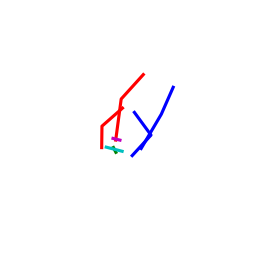

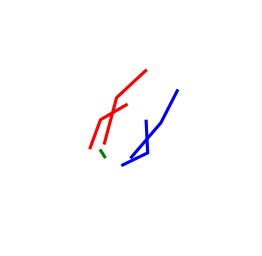

In [ ]:
#zzx sample produce
import numpy as np
target = '/content/drive/MyDrive/HME/Temporal-Transformer/vertices.S6.Sitting 1.58860488_resultsgt.npy'

results = np.load(target, allow_pickle=True) #Example data
kp_3di = results.item()['3d'][25]


plots = []

#Frame number, refer to frame
# i = 15
# kp_3di = results[i]
plots.append(coco_Print(kp_3di))

#Map hmrpred 21->14, h36mgt 17->14
# kp_3di = cocomap(kp_3di)
kp_3di = results.item()['gt_3d'][25]
print('Reduced 14 point correspondance')
plots.append(corModel_Print(kp_3di))

Reduced 14 point correspondance


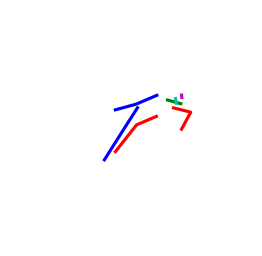

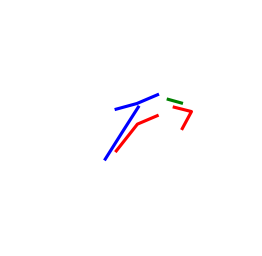

In [ ]:
#RZ- Mapping check
import numpy as np
target = '/content/drive/MyDrive/HME/H36M Data/Cropped Images/TestObjects/sample19.npy'

results = np.load(target, allow_pickle=True) #Example data
plots = []

#Frame number, refer to frame
i = 15
kp_3di = results[i]
plots.append(coco_Print(kp_3di))

#Map hmrpred 21->14, h36mgt 17->14
kp_3di = cocomap(kp_3di)
print('Reduced 14 point correspondance')
plots.append(corModel_Print(kp_3di))


Original data points
Reduced 14 point correspondance


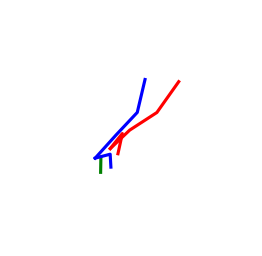

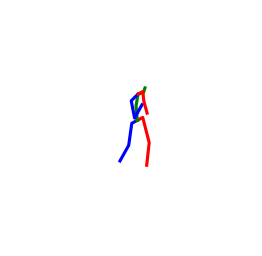

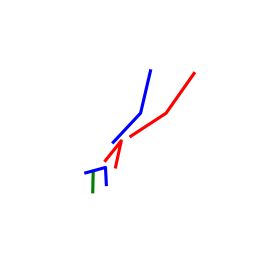

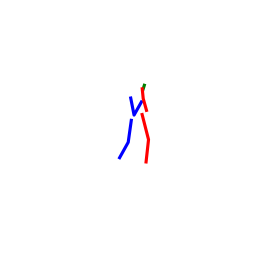

In [ ]:
#RZ- Input output and gt location
# target = '/content/drive/MyDrive/HME/H36M Data/Cropped Images/HMR Outputs/Structure 2_gt/S1/Directions 1.54138969_resultsgt.npy'
target = '/content/drive/MyDrive/HME/H36M Data/Cropped Images/HMR Outputs/Structure 2_gt/S8/Phoning.55011271_resultsgt.npy'


results = np.load(target, allow_pickle=True) #Example data

#Pull the gt data for all frames
gt3d = results[6]
#Pull the predicted data for all frames
kp_3d = results[2]

plots = []

#Frame number, refer to frame
i = 34
kp_3di = kp_3d[i]
gt3di = gt3d[i]
print('Original data points')
plots.append(hmrmodel_Print(kp_3di))
plots.append(model_Print(gt3d[i]))
#Map hmrpred 21->14, h36mgt 17->14
kp_3di = hmrmap(kp_3di)
gti = gtmap(gt3di)
print('Reduced 14 point correspondance')
plots.append(corModel_Print(kp_3di))
plots.append(corModel_Print(gti))